# Model explainability

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import shap
import multiprocessing

random_state = 1
num_cpu = multiprocessing.cpu_count()
num_cpu

/home/gillouche/workspace/exploratory-data-analysis/venv-exploratory-data-analysis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/gillouche/workspace/exploratory-data-analysis/venv-exploratory-data-analysis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


16

In [2]:
def read_data():
    df = pd.read_csv('data/fifa.csv')
    y = (df['Man of the Match'] == "Yes")
    feature_names = [i for i in df.columns if df[i].dtype in [np.int64]]
    X = df[feature_names]
    
    return train_test_split(X, y, random_state=random_state)

## Feature importance with permutation

Train a model, find feature importance by permuting values in a column and see the impact

Creates simple numeric measures to see which features mattered to a model but doesn't tell how each feature matter. If a feature has medium permutation importance, that could mean

* large effect for a few predictions but no effect in general
* medium effect for all predictions

In [3]:
X_train, X_test, y_train, y_test = read_data()

In [4]:
model = RandomForestClassifier(n_estimators=100, random_state=random_state)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [5]:
perm = PermutationImportance(model, random_state=random_state)
perm.fit(X_test, y_test)

PermutationImportance(estimator=RandomForestClassifier(random_state=1),
                      random_state=1)

In [6]:
eli5.explain_weights_df(model, feature_names=X_test.columns.tolist())

,feature,weight,std
0,Goal Scored,0.174837,0.102397
1,Attempts,0.086663,0.072748
2,On-Target,0.079058,0.071841
3,Distance Covered (Kms),0.073441,0.062521
4,Ball Possession %,0.069224,0.060976
5,Pass Accuracy %,0.069150,0.062566
6,Free Kicks,0.064625,0.057324
7,Passes,0.064152,0.063281
8,Corners,0.052681,0.058657
9,Fouls Committed,0.052305,0.056362


## Partial Dependence Plots

calculated after a model has been fit. Repeatedly alter the value for one variable and make a series of predictions. We trace out predicted outomes on the vertical axis as we move from small value of a variable to large value (horizontal axis).

The plot exists in 1D or 2D.

In [7]:
X_train, X_test, y_train, y_test = read_data()

In [8]:
model = DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=random_state)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=1)

In [9]:
feature_names = X_test.columns.tolist()

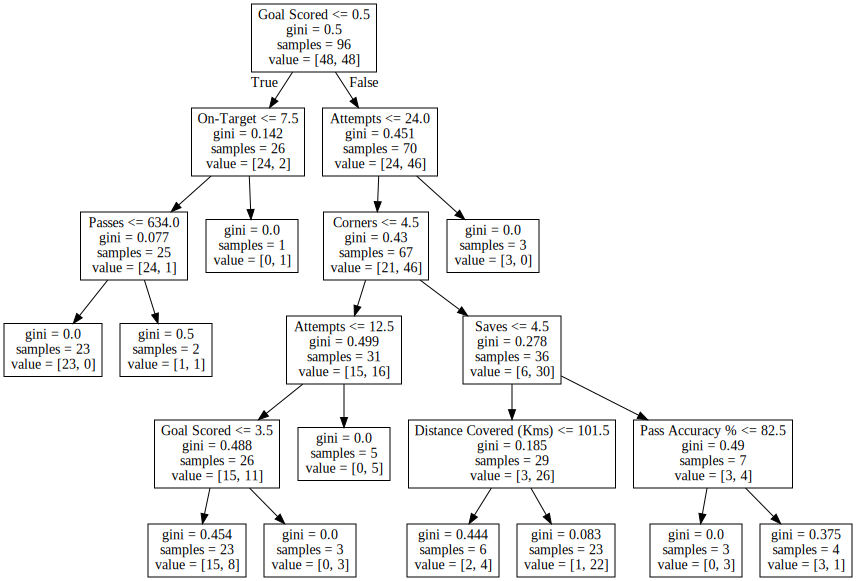

In [10]:
tree_graph = tree.export_graphviz(model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


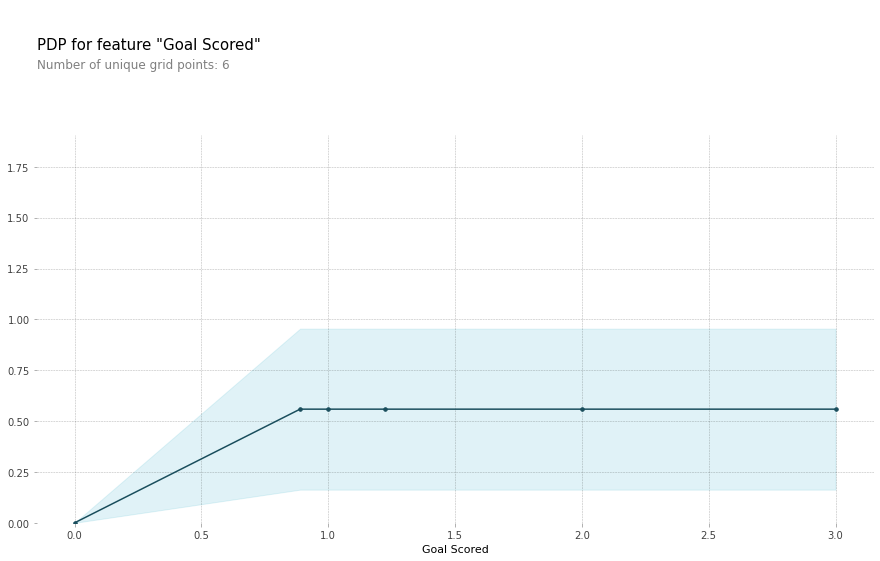

In [11]:
pdp_goals = pdp.pdp_isolate(model=model, dataset=X_test, model_features=feature_names, feature='Goal Scored')

pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or left most value.

The blue shaded area indicates the level of confidence

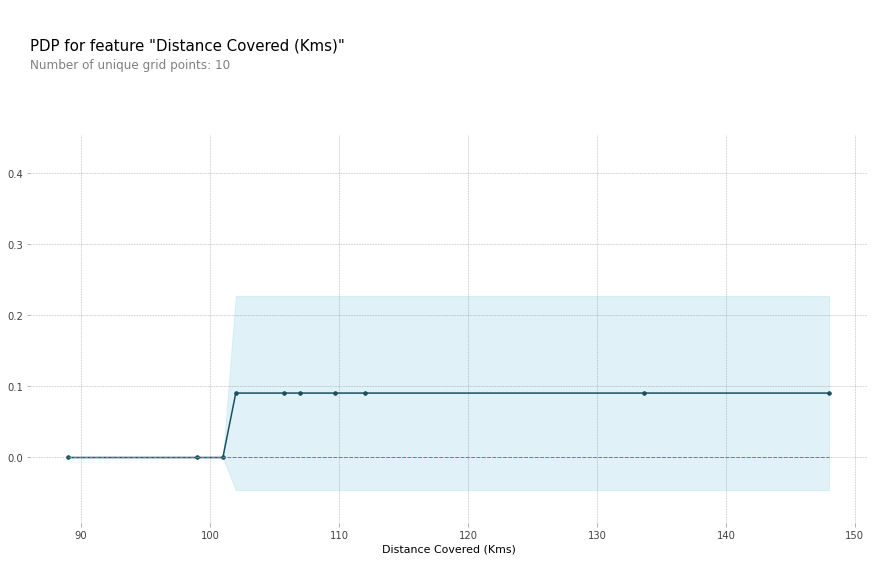

In [12]:
feature_to_plot = 'Distance Covered (Kms)'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

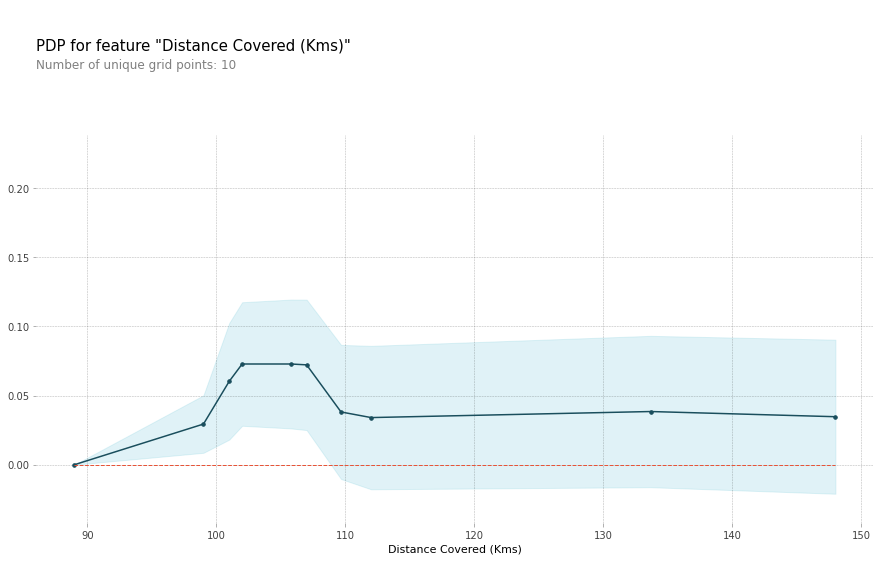

In [13]:
rf_model = RandomForestClassifier(random_state=random_state).fit(X_train, y_train)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=X_test, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

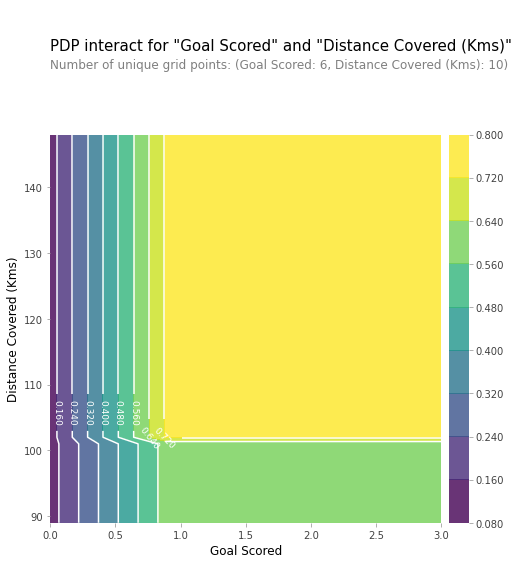

In [14]:
features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']
inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

This graph shows predictions for any combination of Goals Scored and Distance covered.

For example, we see the highest predictions when a team scores at least 1 goal and they run a total distance close to 100km. If they score 0 goals, distance covered doesn't matter.

We can seee this by tracing through the decision tree with 0 goal but distance can impact predictions if they score goals.

## Shapley additive explanations (SHAP)

break down a prediction to show the impact of each feature -> used to explain a single prediction. Shap values show how much a given feature changed our prediction compared to if we made that prediction at some baseline value of that feature.

shap.TreeExplainer for trees explainations

shap.DeepExplainer works well with Deep Learning models

shap.KernelExplainer works with all models but sloweer than other explainers (approximation instead of exact shap values)

In [15]:
X_train, X_test, y_train, y_test = read_data()

In [16]:
model = RandomForestClassifier(random_state=random_state).fit(X_train, y_train)

In [17]:
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

model.predict_proba(data_for_prediction_array)

array([[0.25, 0.75]])

In [18]:
explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [20]:
k_explainer = shap.KernelExplainer(model.predict_proba, X_train)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

### Shap summary plots

Calculate shap values can be slow, xgboost model has some optimization for that.

In [21]:
X_train, X_test, y_train, y_test = read_data()
model = RandomForestClassifier(random_state=random_state).fit(X_train, y_train)

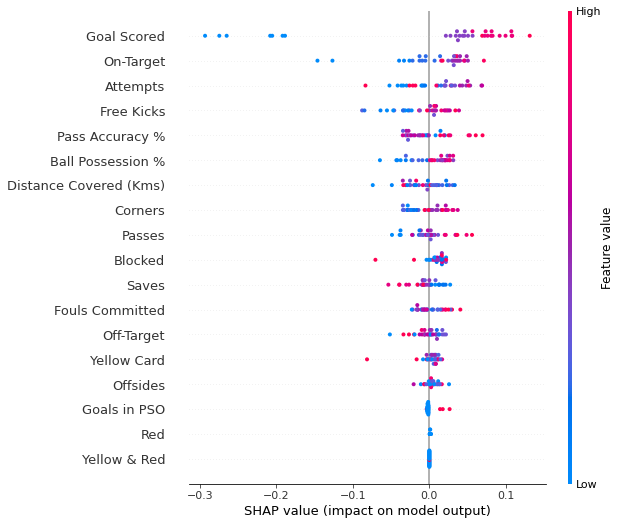

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

Vertical location shows what feature it is depicting

Color shows whether that feature was high or low for that row of the dataset

Horizontal location shows whether the effect of that value caused a higher or lower prediction

### Shap Dependence Contribution Plots

Partial dependence plots showw how a single feature impacts predictions but they don't shoow distribution of effects, is the effect of having a certain value pretty constant, or does it vary a lot depending on the values of other feaures. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

In [23]:
X_train, X_test, y_train, y_test = read_data()
model = RandomForestClassifier(random_state=random_state).fit(X_train, y_train)

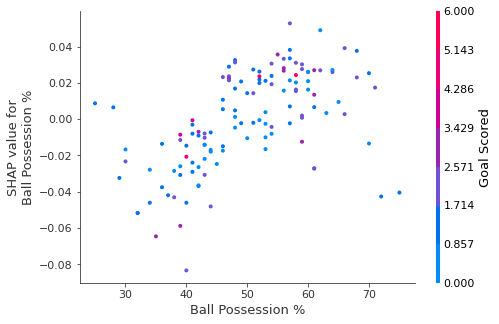

In [24]:
explainer = shap.TreeExplainer(model)

X = pd.concat([X_train, X_test])
shap_values = explainer.shap_values(X)

shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

The two bottom right points stand out spatially as being far away from the upward trend. They are both colored purple, indicating the team scored one goal. You can interpret this to say In general, having the ball increases a team's chance of having their player win the award. But if they only score one goal, that trend reverses and the award judges may penalize them for having the ball so much if they score that little.